In [1]:
### Error/Trend/Seasonality Models


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

In [14]:
airline = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [15]:
airline.dropna(inplace=True)

In [16]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


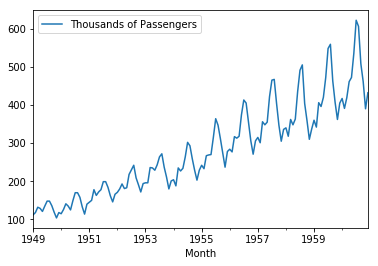

In [17]:
airline.plot()

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

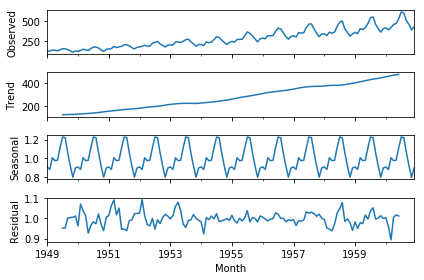

In [19]:
result = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative')  # model='mul' also works
result.plot();

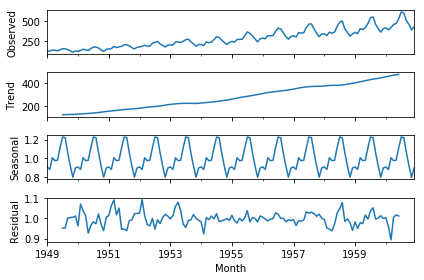

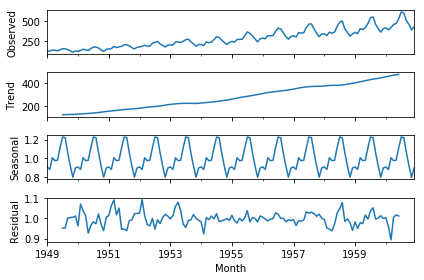

In [26]:
result.plot()

In [27]:
#simple Moving Average


In [29]:
airline['6-month-SMA']=airline['Thousands of Passengers'].rolling(window=6).mean()

In [30]:
airline['12-month-SMA']=airline['Thousands of Passengers'].rolling(window=12).mean()

In [31]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


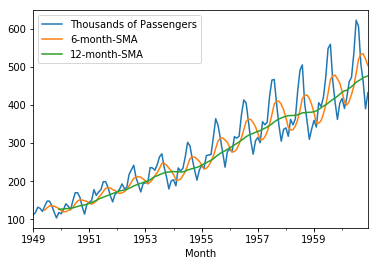

In [32]:
airline.plot()

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:

Smaller windows will lead to more noise, rather than signal
It will always lag by the size of the window
It will never reach to full peak or valley of the data due to the averaging.
Does not really inform you about possible future behavior, all it really does is describe trends in your data.
Extreme historical values can skew your SMA significantly

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size

In [33]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

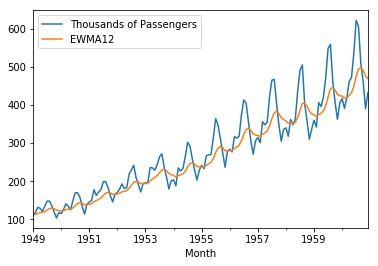

In [34]:
airline[['Thousands of Passengers','EWMA12']].plot();

In [35]:
#Comparing SMA to EWMA

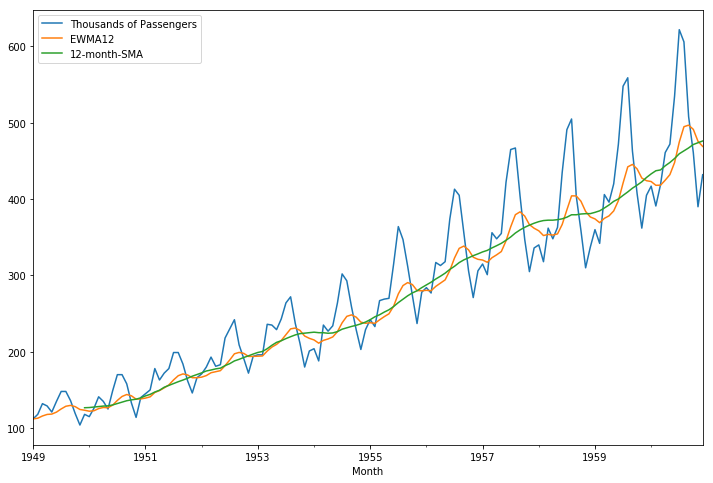

In [36]:
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

Simple Exponential Smoothing
The above example employed Simple Exponential Smoothing with one smoothing factor α. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above. In the next section we'll look at Double and Triple Exponential Smoothing with the Holt-Winters Methods.

# Exponentially Weighted Moving Averages (EWMA) we applied Simple Exponential Smoothing using just one smoothing factor  𝛼  (alpha). This failed to account for other contributing factors like trend and seasonality.

# Double and Triple Exponential Smoothing with the Holt-Winters Methods.

In Double Exponential Smoothing (aka Holt's Method) we introduce a new smoothing factor  𝛽  (beta) that addresses trend:

With Triple Exponential Smoothing (aka the Holt-Winters Method) we introduce a smoothing factor  𝛾  (gamma) that addresses seasonality:



In [41]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [43]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [39]:
#set datetime index a frequency

In [45]:
df.index.freq = 'MS'

In [46]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [47]:
#simple exp smoothing

In [48]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [49]:
span = 12
alpha = 2/(span+1)

In [50]:

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor  𝛼  (alpha), Double Exponential Smoothing adds a second smoothing factor  𝛽  (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ( 0<𝛽≤1 ). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an additive adjustment. If the time series displays an exponential (curved) trend, you would use a multiplicative adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require damping that reduces the size of the trend over future periods until it reaches a flat line.

In [52]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.336774
1949-02-01,118,112.923077,112.923077,120.336774
1949-03-01,132,115.857988,115.857988,134.336774
1949-04-01,129,117.879836,117.879836,131.336774
1949-05-01,121,118.359861,118.359861,123.336774


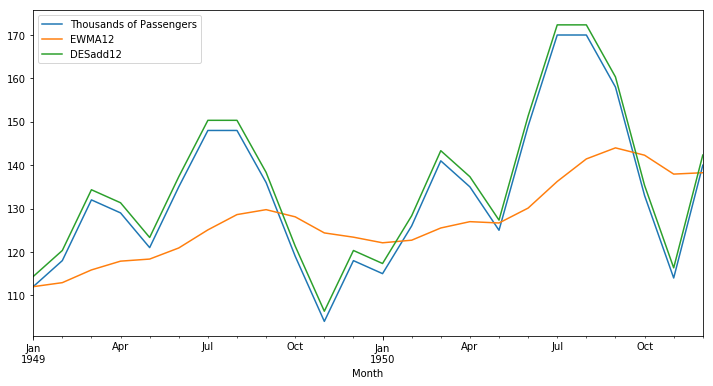

In [53]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# Here we can see that Double Exponential Smoothing is a much better representation of the time series data.
#Let's see if using a multiplicative seasonal adjustment helps

In [56]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.336774,112.049247
1949-02-01,118,112.923077,112.923077,120.336774,118.051885
1949-03-01,132,115.857988,115.857988,134.336774,132.058041
1949-04-01,129,117.879836,117.879836,131.336774,129.056722
1949-05-01,121,118.359861,118.359861,123.336774,121.053204


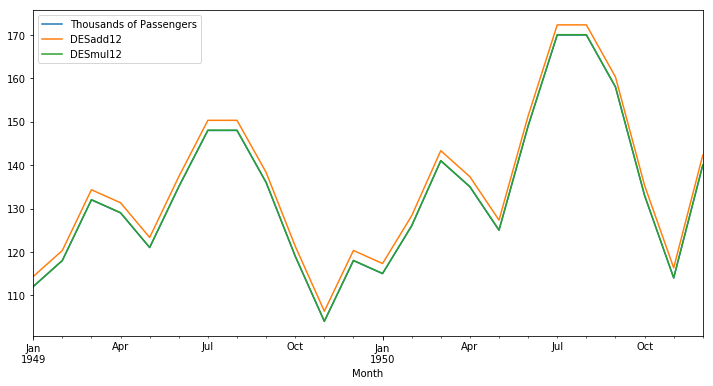

In [57]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

# Triple Exponential Smoothing¶
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data.

In [61]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESmul12,TESadd12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.336774,112.049247,111.753654,113.081280
1949-02-01,118,112.923077,112.923077,120.336774,118.051885,118.993207,120.550730
1949-03-01,132,115.857988,115.857988,134.336774,132.058041,133.458671,135.527373
1949-04-01,129,117.879836,117.879836,131.336774,129.056722,127.957617,133.155127
1949-05-01,121,118.359861,118.359861,123.336774,121.053204,121.027379,125.656203


In [62]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESmul12,TESadd12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.336774,112.049247,111.753654,113.081280
1949-02-01,118,112.923077,112.923077,120.336774,118.051885,118.993207,120.550730
1949-03-01,132,115.857988,115.857988,134.336774,132.058041,133.458671,135.527373
1949-04-01,129,117.879836,117.879836,131.336774,129.056722,127.957617,133.155127
1949-05-01,121,118.359861,118.359861,123.336774,121.053204,121.027379,125.656203


In [63]:
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESmul12,TESadd12
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,114.336774,112.049247,111.753654,113.081280
1949-02-01,118,112.923077,112.923077,120.336774,118.051885,118.993207,120.550730
1949-03-01,132,115.857988,115.857988,134.336774,132.058041,133.458671,135.527373
1949-04-01,129,117.879836,117.879836,131.336774,129.056722,127.957617,133.155127
1949-05-01,121,118.359861,118.359861,123.336774,121.053204,121.027379,125.656203


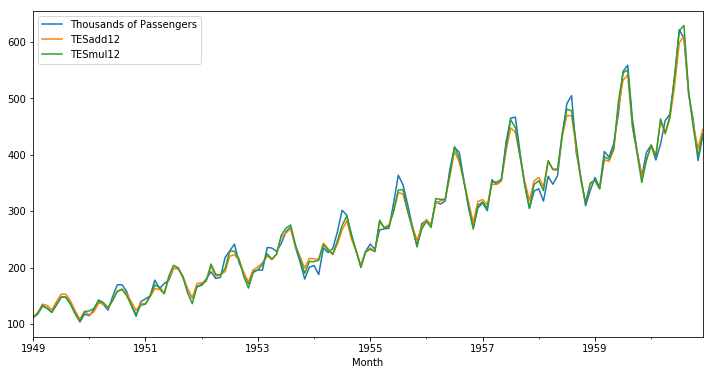

In [64]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

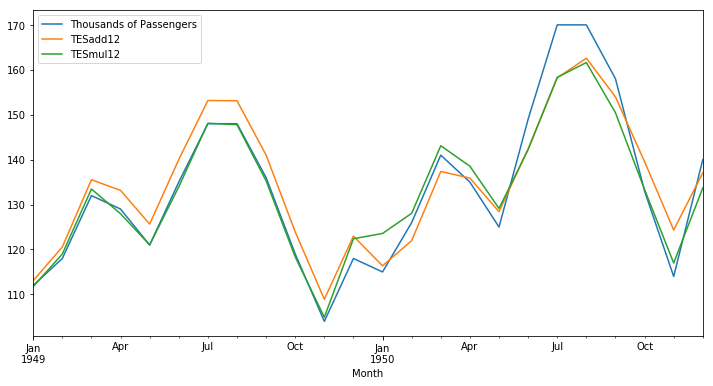

In [65]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [70]:
nbmerge 01-ETS-Decomposition.ipynb7 02-EWMA-Exponentially-Weighted-Moving-Average.ipynb 03-Holt-Winters-Methods.ipynb291 > merged.ipynb


SyntaxError: invalid token (<ipython-input-70-540078f4d45a>, line 1)